In [2]:
import pickle
import os
import sys
sys.path.insert(0, '../olympus')
sys.path.insert(0, '../graphnet/src')
sys.path.insert(0, '../gnn_testbed')
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="0.1"

import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
#from tqdm.auto import tqdm

import numpy as np
import seaborn as sns
import random
from jax import random
from jax import numpy as jnp

import torch
import torch_cluster
import torch_geometric
from torch import Tensor
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from nemesis.event_generation.detector import make_line, generate_noise, Detector, make_triang
from nemesis.plotting import plot_event, plot_events, plot_confusion
from nemesis.data_handling.utils import event_labelling
from nemesis.node_features.feature_generation import generate_features
from nemesis.evaluation.evaluation import model_evaluation
from nemesis.evaluation.utils import count_parameters
from nemesis.models.train import train_model
from nemesis.models.gnns import Dynamic_class, DynEdge_modified

from torch.nn import Linear, Identity, ReLU, Softmax, Dropout, LeakyReLU
import torch.nn.functional as F
from torch_geometric.nn import knn_graph, TAGConv, global_mean_pool, global_max_pool, BatchNorm,  global_add_pool, EdgeConv, DynamicEdgeConv

from graphnet.models.gnn.dynedge import DynEdge
from graphnet.components.layers import DynEdgeConv
from graphnet.models.gnn.gnn import GNN
from graphnet.models.utils import calculate_xyzt_homophily, calculate_xyz_homophily_POne

%matplotlib inline


graphnet: INFO     2023-03-12 20:32:44 - get_logger - Writing log to logs/graphnet_20230312-203244.log


INFO:graphnet:Writing log to logs/graphnet_20230312-203244.log


In [3]:
outpath = "."
plt.rcParams['figure.dpi'] = 100
if torch.cuda.is_available():
    print('CUDA')
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    print('CPU')

CUDA


In [4]:
rng = np.random.RandomState(31338)
oms_per_line = 20
dist_z = 50 # m
dark_noise_rate = 16 * 1e-5  # 1/ns
side_len = 100 # m
pmts_per_module = 16
pmt_cath_area_r = 75E-3 / 2 # m
module_radius = 0.21 # m
v_x = 0
efficiency = pmts_per_module * (pmt_cath_area_r)**2 * np.pi / (4*np.pi*module_radius**2)
det = make_triang(side_len, oms_per_line, dist_z, dark_noise_rate, rng, efficiency=efficiency, v_x=v_x, buoy_weight=30)
module_positions = jnp.asarray(det.module_coords)

In [5]:
#from multiprocessing import Pool
#import pickle
#import numpy as np
#import os
#file_idx = range(12)

def load_all_events(it):
    path_to_events = "/dss/pone/pone_events/all_events"
    load_array = ['cascades_15000ev_3.5-6.5_1.pickle',  'cascades_15000ev_3.5-6.5_2.pickle',
                  'cascades_15000ev_3.5-6.5_3.pickle',  'cascades_15000ev_3.5-6.5_4.pickle',
                  'stracks_15000ev_3.5-6.5_1.pickle',   'stracks_15000ev_3.5-6.5_2.pickle', 
                  'stracks_15000ev_3.5-6.5_3.pickle',   'stracks_15000ev_3.5-6.5_4.pickle', 
                  'tracks_15000ev_3.5-6.5_1.pickle',    'tracks_15000ev_3.5-6.5_2.pickle', 
                  'tracks_15000ev_3.5-6.5_3.pickle',    'tracks_15000ev_3.5-6.5_4.pickle']
            
    events, records = pickle.load(open(os.path.join(path_to_events, load_array[it]), "rb"))
    
    print(f'{it} loaded!')
    
    return events, records

In [ ]:
cascades1, cascade_records1 = load_all_events(0)        
cascades2, cascade_records2 = load_all_events(1)        
cascades3, cascade_records3 = load_all_events(2)        
cascades4, cascade_records4 = load_all_events(3)        
cascades = cascades1 + cascades2 + cascades3 + cascades4
cascade_records = cascade_records1 + cascade_records2 + cascade_records3 + cascade_records4

stracks1, strack_records1 = load_all_events(4)        
stracks2, strack_records2 = load_all_events(5)        
stracks3, strack_records3 = load_all_events(6)  
stracks4, strack_records4 = load_all_events(7)        
stracks = stracks1 + stracks2 + stracks3 + stracks4
strack_records = strack_records1 + strack_records2 + strack_records3 + strack_records4

tracks1, track_records1 = load_all_events(8)
tracks2, track_records2 = load_all_events(9)
tracks3, track_records3 = load_all_events(10)
tracks4, track_records4 = load_all_events(11)
tracks = tracks1 + tracks2 + tracks3 + tracks4
track_records = track_records1 + track_records2 + track_records3 + track_records4

0 loaded!
1 loaded!
2 loaded!
3 loaded!
4 loaded!
5 loaded!
6 loaded!
7 loaded!
8 loaded!


In [ ]:
print(len(cascades), len(cascade_records), len(stracks), len(strack_records), len(tracks), len(track_records))

In [ ]:
cascade_labels, track_labels, strack_labels = event_labelling(track_records, strack_records, cascade_records, det_hull=det.outer_cylinder)

In [ ]:
all_events = cascades + tracks + stracks
all_records = cascade_records + track_records + strack_records
all_labels = cascade_labels + track_labels + strack_labels
print(len(all_events), len(all_records), len(all_labels))

In [ ]:
data_array = generate_features(det, all_events, all_labels, k=15)

In [ ]:
#pickle.dump(data_array, open("/dss/pone/pone_events/features_arrays/data_array_180k_k8_Rout_right.pickle", "wb"))
data_array = pickle.load(open("/dss/pone/pone_events/features_arrays/data_array_180k_k15_Rout.pickle", "rb"))

In [10]:
import random
random.seed(2039)

indices = np.arange(len(data_array))
random.shuffle(indices)


shuffled_data = [data_array[i] for i in indices]
split_test = int(len(shuffled_data)*0.9)
training_data = shuffled_data[:split_test]
split_val = int(len(training_data)*0.9)
train_dataset = training_data[:split_val]
val_dataset = training_data[split_val:]

test_dataset = shuffled_data[split_test:]
test_indices = indices[split_test:]

In [6]:
import torch
from torch import Tensor
from torch.nn import Linear, Identity, ReLU, BatchNorm1d, LeakyReLU
import torch.nn.functional as F
from torch_geometric.nn import TAGConv, global_max_pool, BatchNorm, DynamicEdgeConv
from typing import Any, Dict, List, Optional, Union
from torch_geometric.typing import NoneType
from torch_scatter import scatter_max, scatter_mean, scatter_min, scatter_sum

from graphnet.models.gnn.gnn import GNN
from graphnet.components.layers import DynEdgeConv
from nemesis.models.utils import calculate_xyz_homophily_POne

graphnet: INFO     2023-03-12 10:37:05 - get_logger - Writing log to logs/graphnet_20230312-103705.log


INFO:graphnet:Writing log to logs/graphnet_20230312-103705.log


In [7]:
class DynEdge_modified(GNN):
    def __init__(self, input_features, output_features, k = 15, features_subset = slice(12, 15), layer_size_scale=4):
        
        #Architecture configuration
        c = layer_size_scale
        l1, l2, l3, l4, l5, l6, l7 = (
            input_features, c * 16 * 2, c * 32 * 2, c * 64 * 2, c * 32 * 2, c * 512 * 2, output_features)
        
        #Base class constructor
        super().__init__(l1, l6)
        
        #First Layer
        self.conv_add1 = DynEdgeConv(
            torch.nn.Sequential(Linear(l1*2, l2),LeakyReLU(),Linear(l2, l3),LeakyReLU()),
            aggr="max",
            nb_neighbors=k,
            features_subset=features_subset)              
          
        #Second Layer  
        self.conv_add2 = DynEdgeConv(
            torch.nn.Sequential(Linear(l3*2, l4), LeakyReLU(), Linear(l4, l3), LeakyReLU()),
            aggr="add",
            nb_neighbors=k,
            features_subset=features_subset)
        
        #Third Layer
        self.conv_add3 = DynEdgeConv(
            torch.nn.Sequential(Linear(l3*2, l4),LeakyReLU(),Linear(l4, l3),LeakyReLU()),
            aggr="max",
            nb_neighbors=k,
            features_subset=features_subset)
        
        #Fourth Layer
        self.conv_cat1 = DynEdgeConv(
            torch.nn.Sequential(Linear(l3*2, l4),LeakyReLU(),Linear(l4, l3),LeakyReLU()),
            aggr="add",
            nb_neighbors=k,
            features_subset=features_subset)
        
        #Linear layers
        self.nn1 = Linear(l3*4 + l1, l4)
        self.nn2 = Linear(l4, l5)
        self.nn3 = Linear(4*l5 + 3, l6)
        self.lrelu = LeakyReLU()
        
        self.mlp = MLP([l6, l6/2, l6/8, l6/32, l7], dropout=0.5)
        
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        h_x, h_y, h_z = calculate_xyz_homophily_POne(x, edge_index, batch)
        
        global_means = scatter_mean(x, batch, dim=0)
        
        a, edge_index = self.conv_add1(x, edge_index, batch)
        b, edge_index = self.conv_add2(a, edge_index, batch)
        c, edge_index = self.conv_add3(b, edge_index, batch)
        d, edge_index = self.conv_cat1(c, edge_index, batch)
        
        #Skip cat
        x = torch.cat((x, a, b, c, d), dim=1)
        
        #Post-processing
        x = self.nn1(x)
        x = self.lrelu(x)
        x = self.nn2(x)
        
        #Aggregation across nodes
        a, _ = scatter_max(x, batch, dim=0)
        b, _ = scatter_min(x, batch, dim=0)
        c = scatter_sum(x, batch, dim=0)
        d = scatter_mean(x, batch, dim=0)
        
        #Cat aggr and scalar feats
        
        x = torch.cat((a, b, c, d, h_x, h_y, h_z), dim=1)
        
        #Readout
        
        x = self.lrelu(x)
        x = self.nn3(x)
        
        x = self.lrelu(x)
        
        return x     

In [13]:
torch.cuda.empty_cache()

+-----------------------+------------+
|        Modules        | Parameters |
+-----------------------+------------+
| conv_add1.nn.0.weight |    3840    |
|  conv_add1.nn.0.bias  |    128     |
| conv_add1.nn.2.weight |   32768    |
|  conv_add1.nn.2.bias  |    256     |
| conv_add2.nn.0.weight |   262144   |
|  conv_add2.nn.0.bias  |    512     |
| conv_add2.nn.2.weight |   131072   |
|  conv_add2.nn.2.bias  |    256     |
| conv_add3.nn.0.weight |   262144   |
|  conv_add3.nn.0.bias  |    512     |
| conv_add3.nn.2.weight |   131072   |
|  conv_add3.nn.2.bias  |    256     |
| conv_cat1.nn.0.weight |   262144   |
|  conv_cat1.nn.0.bias  |    512     |
| conv_cat1.nn.2.weight |   131072   |
|  conv_cat1.nn.2.bias  |    256     |
|       nn1.weight      |   531968   |
|        nn1.bias       |    512     |
|       nn2.weight      |   131072   |
|        nn2.bias       |    256     |
|       nn3.weight      |    4108    |
|        nn3.bias       |     4      |
+-----------------------+

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 000, Train Acc: 0.7405, Val Acc: 0.8340, patience: 0
Epoch: 001, Train Acc: 0.8531, Val Acc: 0.8594, patience: 1
Epoch: 002, Train Acc: 0.8703, Val Acc: 0.8783, patience: 1
Epoch: 003, Train Acc: 0.8802, Val Acc: 0.8843, patience: 1
Epoch: 004, Train Acc: 0.8861, Val Acc: 0.8844, patience: 1
Epoch: 005, Train Acc: 0.8926, Val Acc: 0.8902, patience: 1
Epoch: 006, Train Acc: 0.8982, Val Acc: 0.8849, patience: 1
Epoch: 007, Train Acc: 0.9018, Val Acc: 0.8871, patience: 2
Epoch: 008, Train Acc: 0.9049, Val Acc: 0.8933, patience: 3
Epoch: 009, Train Acc: 0.9074, Val Acc: 0.8964, patience: 1
Epoch: 010, Train Acc: 0.9104, Val Acc: 0.8951, patience: 1
Epoch: 011, Train Acc: 0.9124, Val Acc: 0.8893, patience: 2
Epoch: 012, Train Acc: 0.9158, Val Acc: 0.8940, patience: 3
Epoch: 013, Train Acc: 0.9191, Val Acc: 0.8983, patience: 4
Epoch: 014, Train Acc: 0.9200, Val Acc: 0.8991, patience: 1
Epoch: 015, Train Acc: 0.9217, Val Acc: 0.8948, patience: 1
Epoch: 016, Train Acc: 0.9250, Val Acc: 

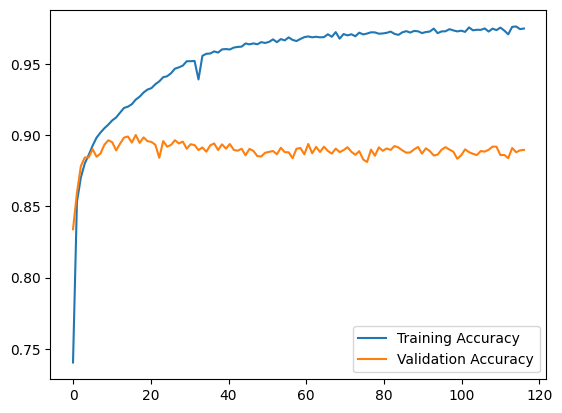

In [14]:
model = DynEdge_modified(15, 4, k = 15, features_subset = slice(12, 15), layer_size_scale=4)

model.to(device)
count_parameters(model)

label_map = {0:"Contained cascade", 1:'Throughgoing Track', 2:"Starts in detector", 3:"Rest of events"}
model, all_trains_acc, all_vals_acc = train_model(model, train_dataset, val_dataset, label_map, k=8, epochs=200, patience=100, print_step=1, batch_size=200, lr=0.001)
plt.plot(np.linspace(0, len(all_trains_acc), len(all_trains_acc)), all_trains_acc, label="Training Accuracy")
plt.plot(np.linspace(0, len(all_vals_acc), len(all_vals_acc)), all_vals_acc, label="Validation Accuracy")
plt.legend()
plt.show()


In [36]:
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=False)
fig1, miss_idx1, test_acc=model_evaluation(model, test_loader, all_events, all_records, all_labels, label_map, test_indices)
print('The test accuracy achieved is: ', test_acc)

NameError: name 'DataLoader' is not defined

In [17]:
path_to_models = "/dss/pone/nemesis_trained_models/"
#model = torch.load(os.path.join(outpath, "Dynmod_model_180k_R_75.pt"))
torch.save(model, os.path.join(outpath, "DynMod_model_180k_Rout_B200_L4_lr0.001_weight1e-5_k8.pt"))

In [18]:
import pickle
import os
import functools
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="0.8"
import sys
sys.path.insert(0, '../olympus')
sys.path.insert(0, '../hyperion')
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from itertools import product
import awkward as ak
import pandas as pd
from olympus.event_generation.photon_propagation.norm_flow_photons import make_generate_norm_flow_photons, make_nflow_photon_likelihood
from olympus.event_generation.photon_propagation.utils import sources_to_model_input
from nemesis.event_generation.detector import Detector, make_line, make_triang
from olympus.event_generation.event_generation import (
    generate_cascade,
    generate_cascades,
    simulate_noise,
    generate_realistic_track,
    generate_realistic_tracks,
    generate_realistic_tracks_test,
    generate_realistic_starting_tracks,)
from olympus.event_generation.lightyield import make_pointlike_cascade_source, make_realistic_cascade_source
from olympus.event_generation.utils import sph_to_cart_jnp, proposal_setup

#from olympus.plotting import plot_event
from hyperion.medium import medium_collections
from hyperion.constants import Constants
import jax
jax.config.update('jax_platform_name', 'cpu')
from jax import random
from jax import numpy as jnp
import json

path_to_config = "../hyperion/data/pone_config_optimistic.json"
config = json.load(open(path_to_config))["photon_propagation"]
ref_ix_f, sca_a_f, sca_l_f, _ = medium_collections[config["medium"]]

def c_medium_f(wl):
    """Speed of light in medium for wl (nm)."""
    return Constants.BaseConstants.c_vac / ref_ix_f(wl)

rng = np.random.RandomState(31338)
oms_per_line = 20
dist_z = 50 # m
dark_noise_rate = 16 * 1e-5  # 1/ns
side_len = 100 # m
pmts_per_module = 16
pmt_cath_area_r = 75E-3 / 2 # m
module_radius = 0.21 # m



/home/work/.local/lib/python3.10/site-packages/jax/_src/api_util.py:222: SyntaxWarning: Jitted function has invalid argnames {'interactions'} in static_argnames. Function does not take these args.This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has invalid argnames {invalid_argnames} "


In [28]:
path_to_events = "/dss/pone/pone_events"
det, cascades, cascade_records = pickle.load(open(os.path.join(path_to_events, f"cascades1500_vx0.005.pickle"), "rb"))

In [29]:
det, tracks, track_records = pickle.load(open(os.path.join(path_to_events, f"tracks1500_vx0.005.pickle"), "rb"))
det, stracks, strack_records = pickle.load(open(os.path.join(path_to_events, f"starting_tracks1500_vx0.005.pickle"), "rb"))

In [30]:
cascades_test = cascades
cascade_records_test = cascade_records
tracks_test = tracks
track_records_test = track_records
stracks_test = stracks
strack_records_test = strack_records

In [24]:
rng = np.random.RandomState(31338)
oms_per_line = 20
dist_z = 50 # m
dark_noise_rate = 16 * 1e-5  # 1/ns
side_len = 100 # m
pmts_per_module = 16
pmt_cath_area_r = 75E-3 / 2 # m
module_radius = 0.21 # m
v_x = 0

efficiency = pmts_per_module * (pmt_cath_area_r)**2 * np.pi / (4*np.pi*module_radius**2)
det = make_triang(side_len, oms_per_line, dist_z, dark_noise_rate, rng, efficiency=efficiency, v_x=v_x, buoy_weight=30)
module_positions = jnp.asarray(det.module_coords)

In [31]:
cascade_labels_test, track_labels_test, strack_labels_test = event_labelling(track_records_test, strack_records_test, cascade_records_test, det_hull=[75, 1100])
all_events_test = cascades_test + tracks_test + stracks_test
all_records_test = cascade_records_test + track_records_test + strack_records_test
all_labels_test = cascade_labels_test + track_labels_test + strack_labels_test

/home/work/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

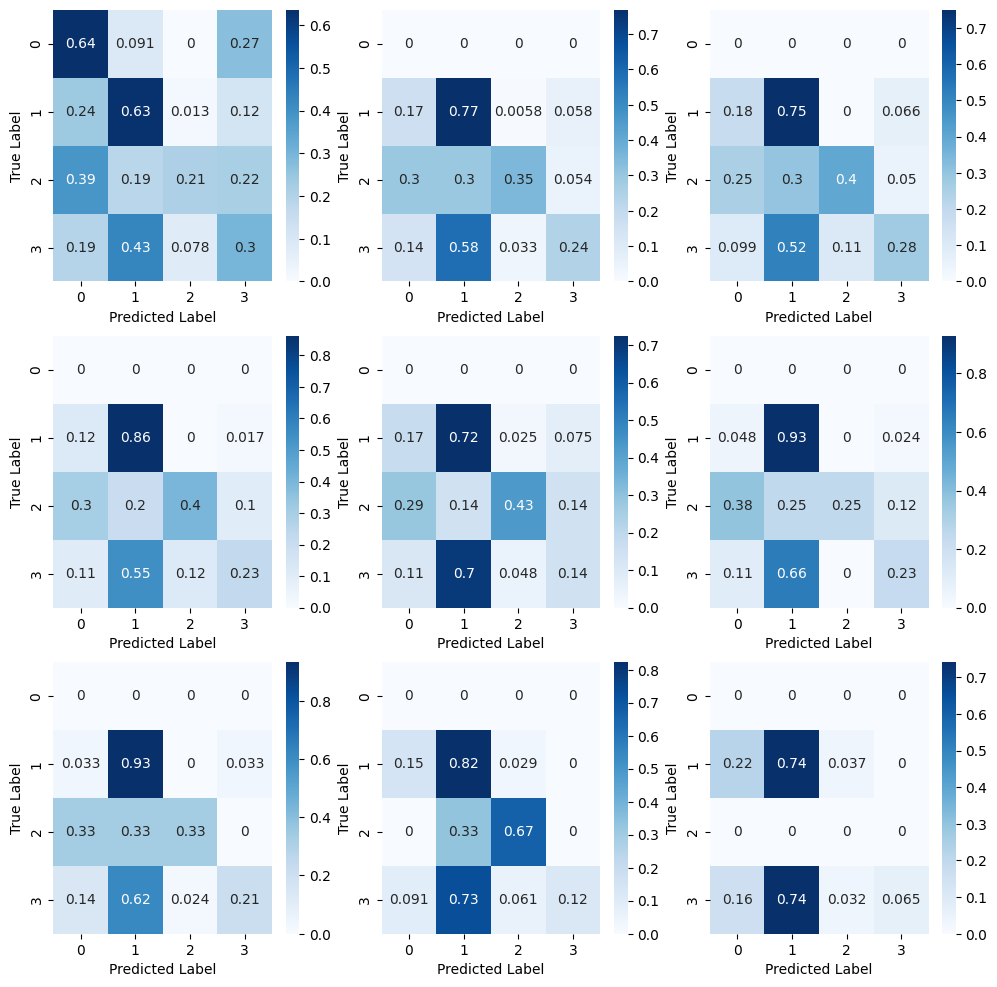

The accuracies of the different energy divisions are [39.555692687442146, 45.333333333333336, 43.881856540084385, 46.58385093167702, 37.27272727272727, 53.608247422680414, 50.666666666666664, 48.57142857142857, 37.93103448275862]


In [26]:
gaps_to_evaluate = energy_gap_test(det, model, all_events_test, all_records_test, all_labels_test, num_divisions=10, k=8)
energy_divisions = gaps_to_evaluate.energy_division_loaders()
fig, test_accuracies, misscls_idx = gaps_to_evaluate.energy_evaluation()

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

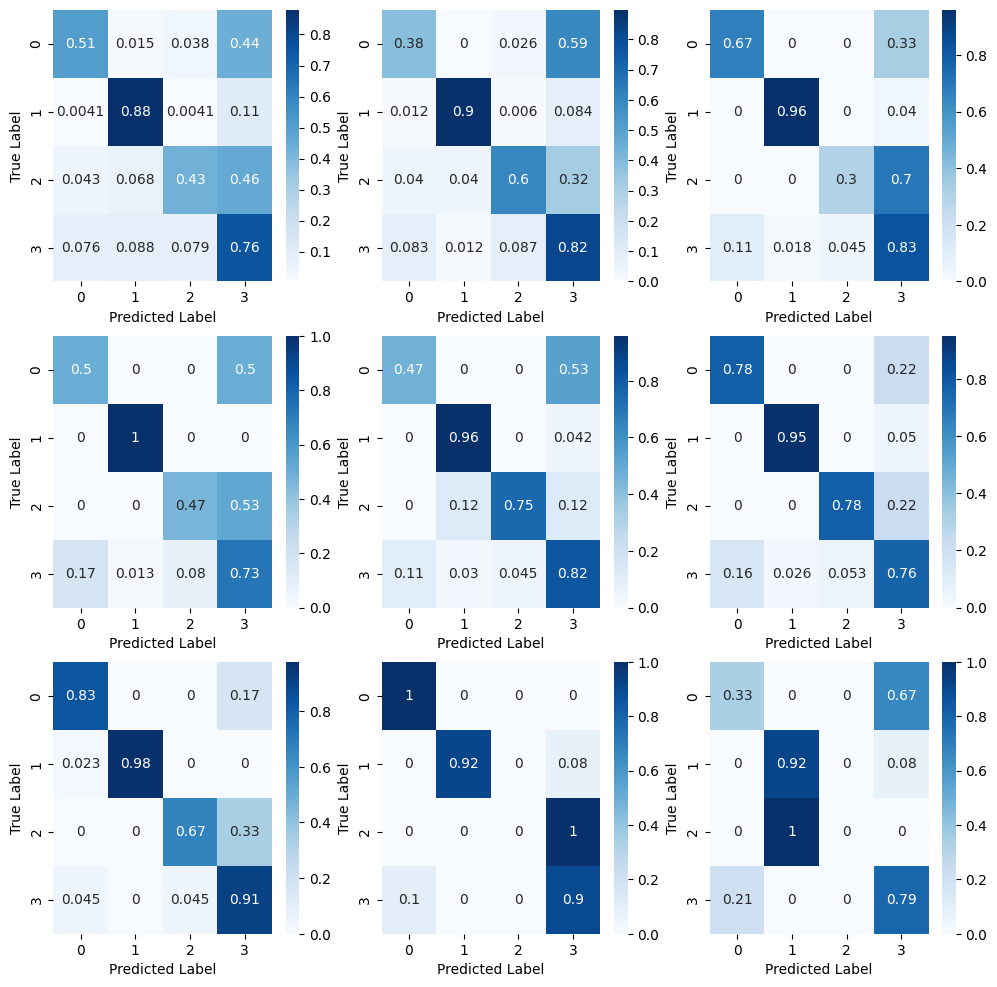

The accuracies of the different energy divisions are [73.61328737073018, 79.83014861995754, 84.7107438016529, 80.0, 82.48175182481752, 84.375, 93.24324324324324, 89.47368421052632, 78.57142857142857]


In [32]:
gaps_to_evaluate = energy_gap_test(det, model, all_events_test, all_records_test, all_labels_test, num_divisions=10, k=8)
energy_divisions = gaps_to_evaluate.energy_division_loaders()
fig, test_accuracies, misscls_idx = gaps_to_evaluate.energy_evaluation()

In [27]:
energy_divisions = gaps_to_evaluate.energy_divisions
test_accuracies = gaps_to_evaluate.test_accuracies
a = plt.plot(energy_divisions[:-1], test_accuracies)
plt.show()

AttributeError: 'energy_gap_test' object has no attribute 'energy_divisions'